<a href="https://colab.research.google.com/github/Rahulraj31/Autoencoder_MNIST-Fashion/blob/main/MNIST_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Using Autoencoders on MNIST Fashion Dataset</h1>


**dataset = https://www.kaggle.com/zalando-research/fashionmnist**

In [ ]:
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt

from imgaug import augmenters
from random import randint

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import Flatten,Dense, Input, Conv2D,MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal

In [ ]:
# read dataset
train=pd.read_csv("/content/fashion-mnist_train.csv")
train_x = train[list(train.columns[1:])].values
train_y = train['label'].values

# For Image Denoising

In [ ]:
## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2,random_state=42)

# Normalize it 
train_x= train_x / 255
val_x =val_x/255

In [ ]:
#Reshaping data for CNN
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

**Noisy Images**

We can intentionally introduce the noise in an image. I am using imaug package which can be used to augment the images with different variations. One such variation can be introduction of noise. Different types of noises can be added to the images. For example:

Salt and Pepper Noise

Gaussian Noise

Periodic Noise

Speckle Noise

Lets introduce salt and pepper noise to our data which is also known as impulse noise. This noise introduces sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels.

In [ ]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

### Before adding noise

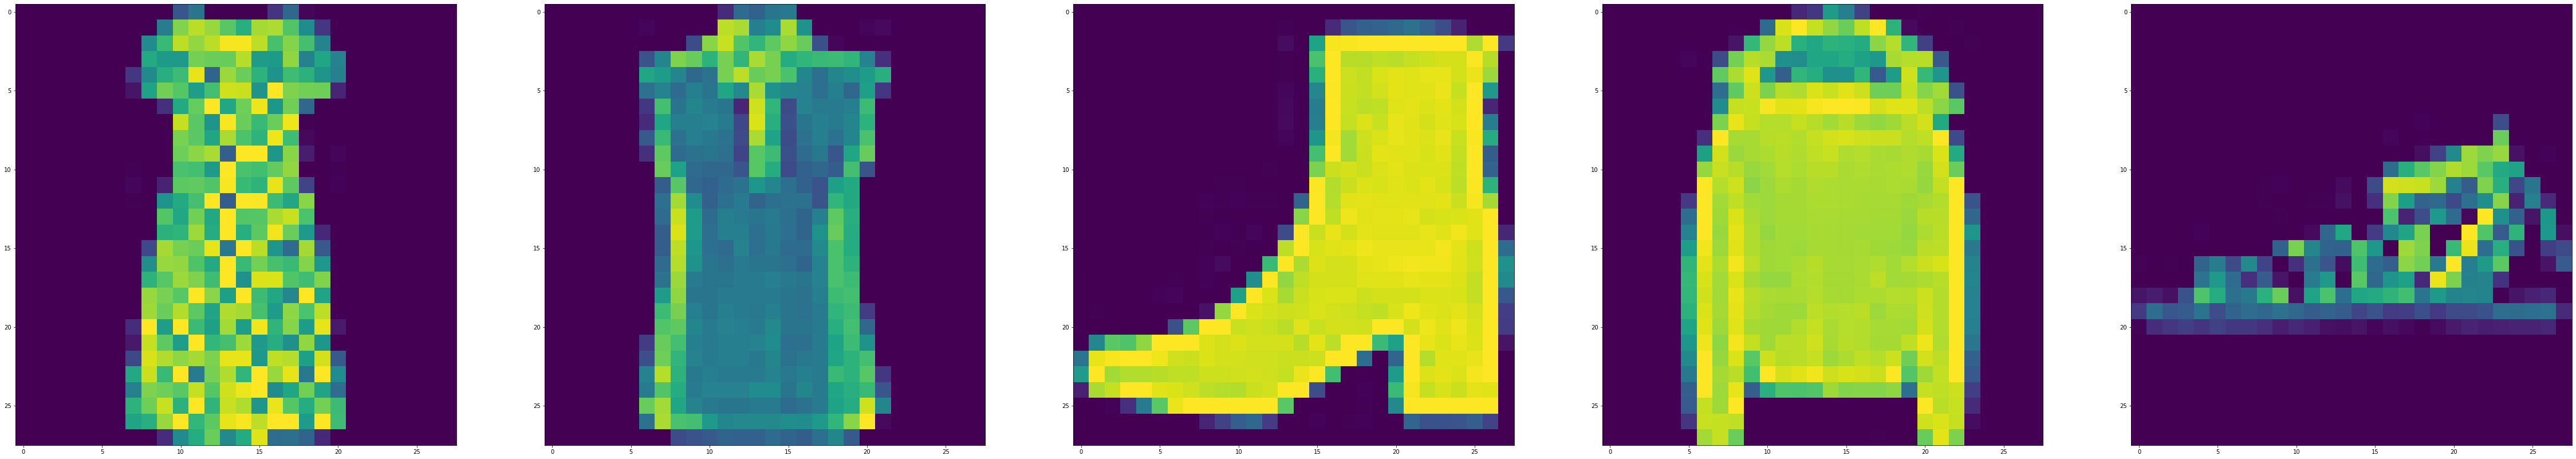

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

### After adding noise

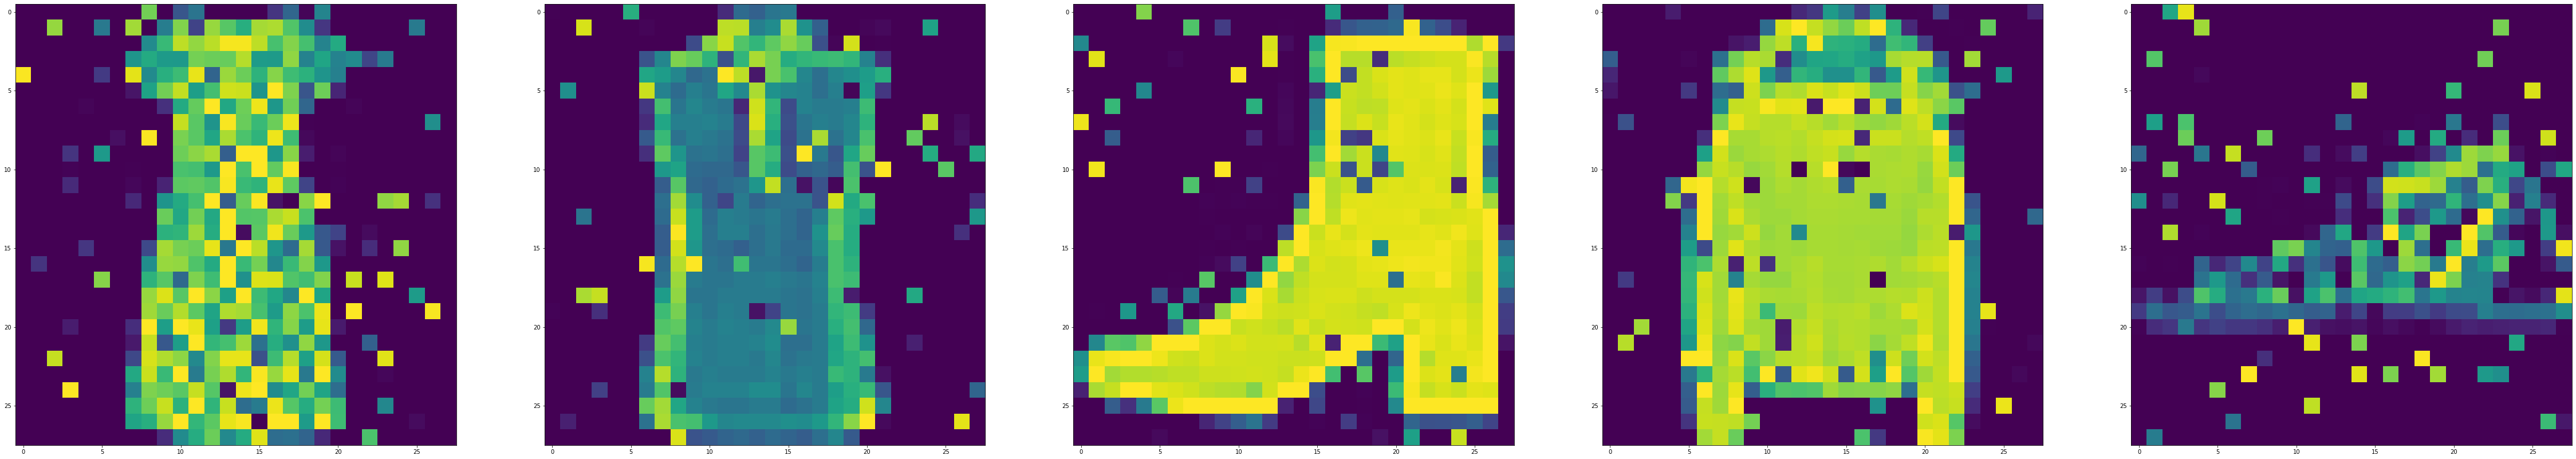

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

### Encoding Architecture:

The encoding architure is composed of 3 Convolutional Layers and 3 Max Pooling Layers stacked one by one. Relu is used as the activation function in the convolution layers and padding is kept as "same". Role of max pooling layer is to downsample the image dimentions. This layer applies a max filter to non-overlapping subregions of the initial representation.


### Decoding Architecture:

Similarly in decoding architecture, the convolution layers will be used having same dimentions (in reverse manner) as the encoding architecture. But instead of 3 maxpooling layers, we will be adding 3 upsampling layers. Again the activation function will be same (relu), and padding in convolution layers will be same as well. Role of upsampling layer is to upsample the dimentions of a input vector to a higher resolution / dimention. The max pooling operation is non-invertible, however an approximate inverse can be obtained by recording the locations of the maxima within each pooling region. Umsampling layers make use of this property to project the reconstructions from a low dimentional feature space.

In [ ]:
# input layer 
input_layer = Input(shape=(28, 28, 1))

# Encoding Architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)

encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)

encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)

latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)

decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)

decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)


output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

#dimension of output layer == input layer coz we need denoised image thats why there is no dense layer only Conv layer 


In [ ]:
# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 16)          0   

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,
                               patience=10, verbose=5, mode='auto')


history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/10
24/24 [==============================] - 201s 8s/step - loss: 0.0889 - val_loss: 0.0564
Epoch 2/10
24/24 [==============================] - 194s 8s/step - loss: 0.0446 - val_loss: 0.0360
Epoch 3/10
24/24 [==============================] - 195s 8s/step - loss: 0.0338 - val_loss: 0.0314
Epoch 4/10
24/24 [==============================] - 199s 8s/step - loss: 0.0298 - val_loss: 0.0278
Epoch 5/10
24/24 [==============================] - 193s 8s/step - loss: 0.0267 - val_loss: 0.0253
Epoch 6/10
24/24 [==============================] - 195s 8s/step - loss: 0.0249 - val_loss: 0.0245
Epoch 7/10
24/24 [==============================] - 199s 8s/step - loss: 0.0234 - val_loss: 0.0226
Epoch 8/10
24/24 [==============================] - 196s 8s/step - loss: 0.0222 - val_loss: 0.0216
Epoch 9/10
24/24 [==============================] - 195s 8s/step - loss: 0.0213 - val_loss: 0.0208
Epoch 10/10
24/24 [==============================] - 191s 8s/step - loss: 0.0205 - val_loss: 0.0200


Increase epochs and tune it for better accuracy Lets obtain the predictions of the model

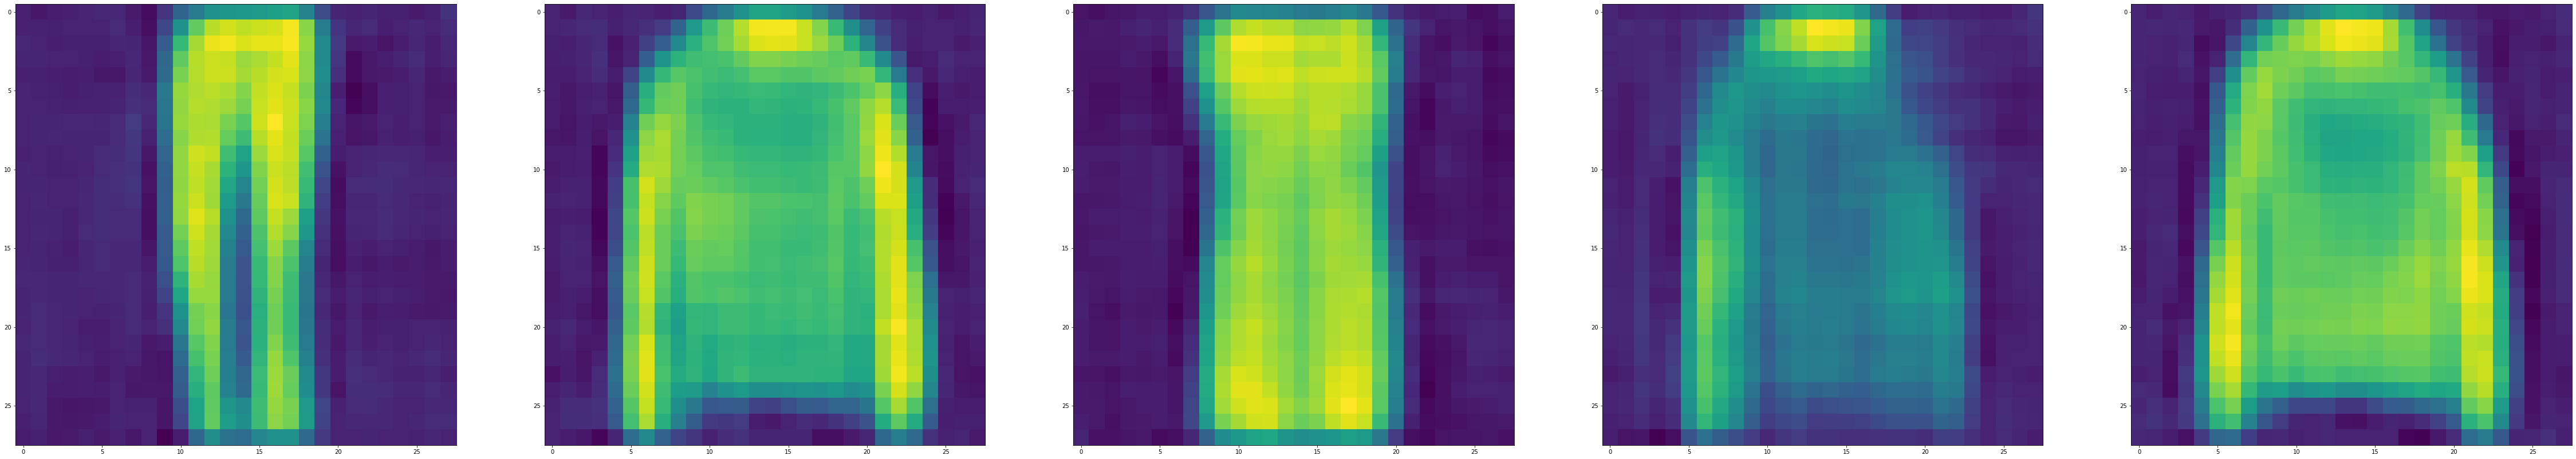

In [ ]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()

#------------ BONUS------------

# For Image Reconstruction using Autoencoder

In [ ]:
### read dataset 
train = pd.read_csv("/content/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

train_x.shape

(48000, 784)

In [ ]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 1500)              1177500   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              5010

In [ ]:
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, 
                               patience=10, verbose=1, mode='auto')

model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Epoch 1/20
24/24 [==============================] - 34s 1s/step - loss: 0.0947 - val_loss: 0.0705
Epoch 2/20
24/24 [==============================] - 33s 1s/step - loss: 0.0648 - val_loss: 0.0570
Epoch 3/20
24/24 [==============================] - 33s 1s/step - loss: 0.0522 - val_loss: 0.0456
Epoch 4/20
24/24 [==============================] - 33s 1s/step - loss: 0.0423 - val_loss: 0.0394
Epoch 5/20
24/24 [==============================] - 32s 1s/step - loss: 0.0378 - val_loss: 0.0366
Epoch 6/20
24/24 [==============================] - 33s 1s/step - loss: 0.0352 - val_loss: 0.0332
Epoch 7/20
24/24 [==============================] - 35s 1s/step - loss: 0.0321 - val_loss: 0.0304
Epoch 8/20
24/24 [==============================] - 32s 1s/step - loss: 0.0283 - val_loss: 0.0270
Epoch 9/20
24/24 [==============================] - 31s 1s/step - loss: 0.0265 - val_loss: 0.0262
Epoch 10/20
24/24 [==============================] - 31s 1s/step - loss: 0.0251 - val_loss: 0.0245
Epoch 11/20
24/24 [

In [ ]:
preds = model.predict(val_x)

Lets plot the original and predicted image

Inputs: Actual Images

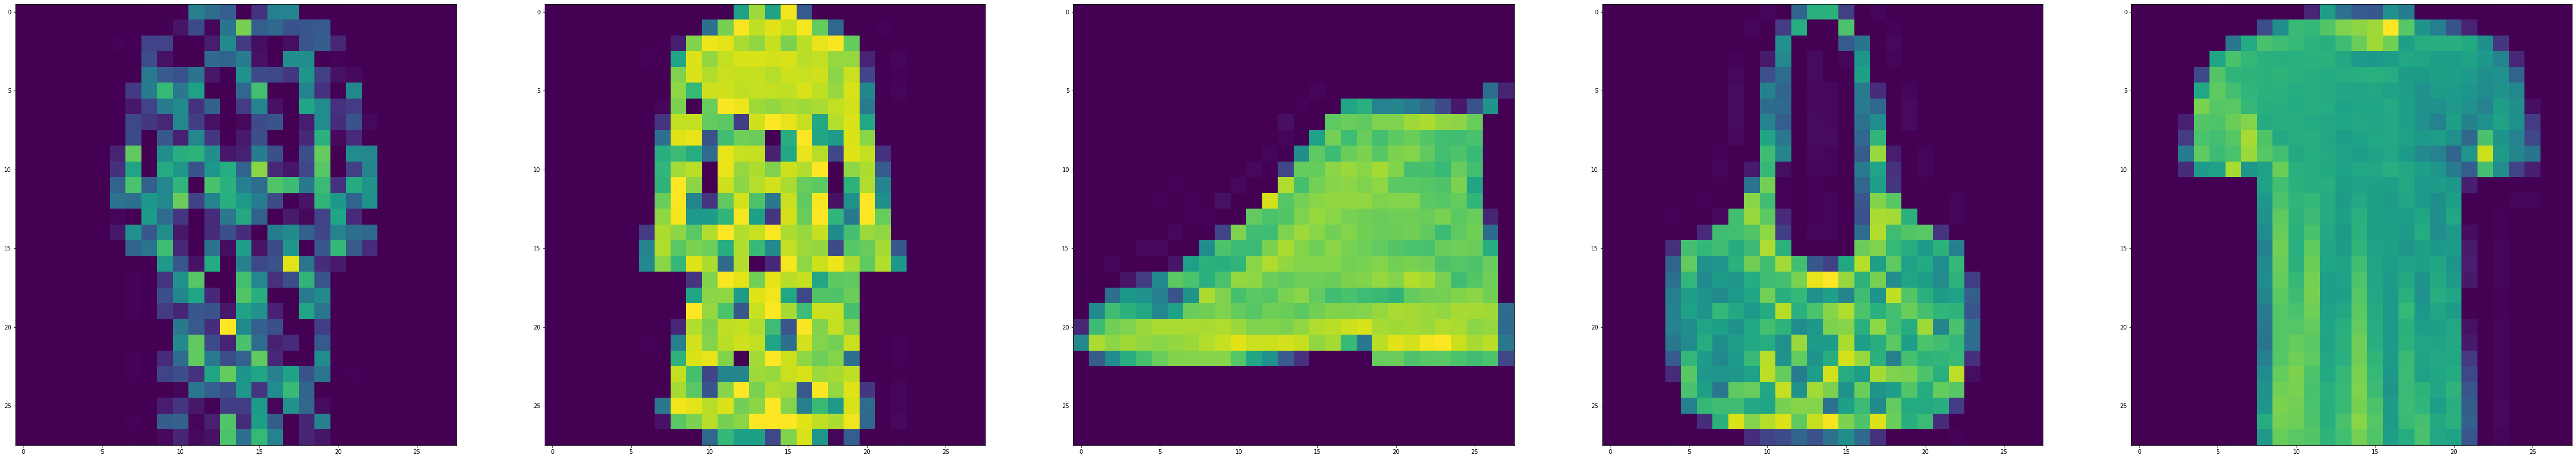

In [ ]:
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

Predicted : Autoencoder Output

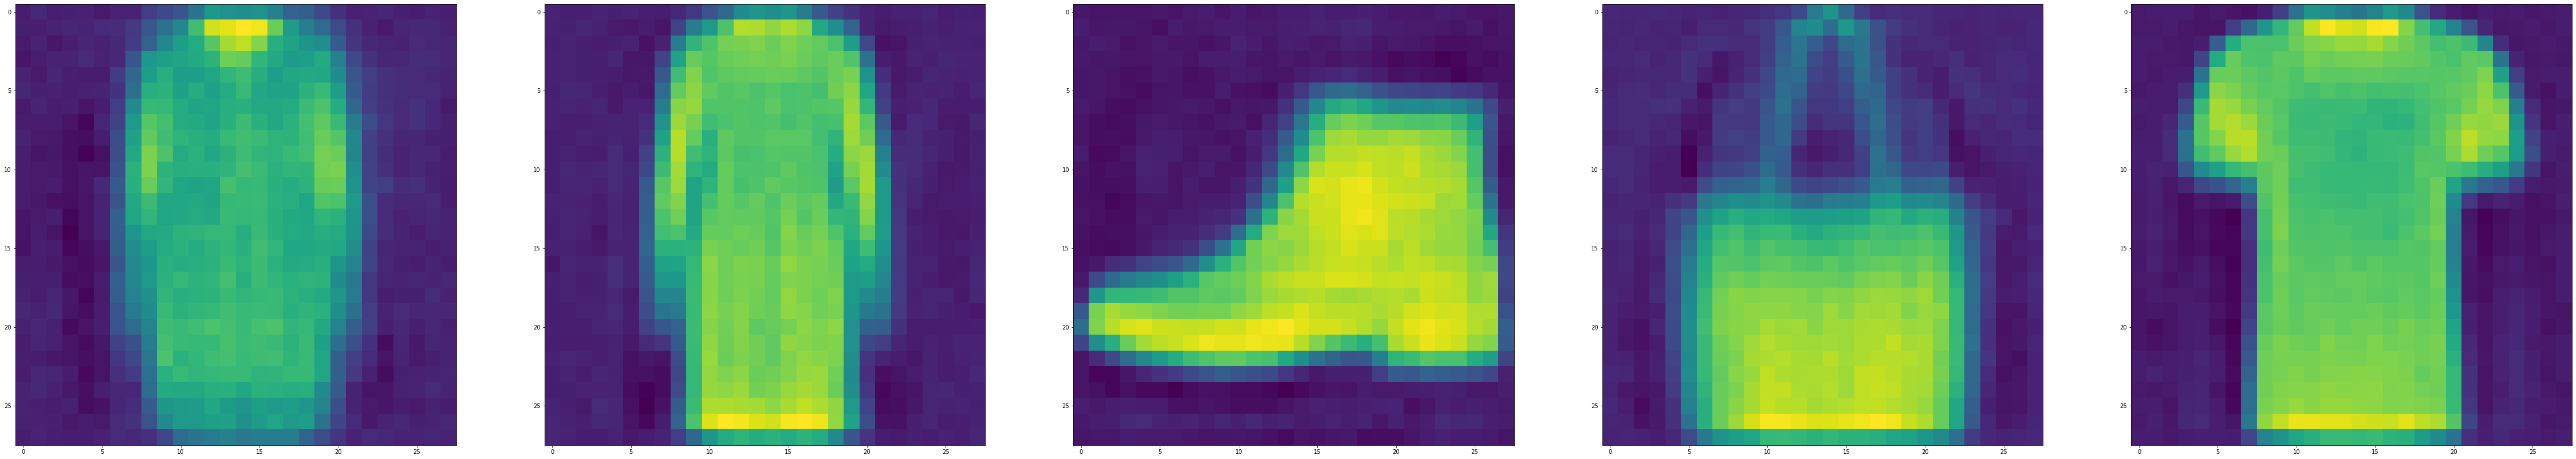

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()